# Importing Packages

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale 
from sklearn.metrics import confusion_matrix,accuracy_score

In [3]:
# for Optimization
import cvxopt.solvers
from cvxopt import matrix as cm

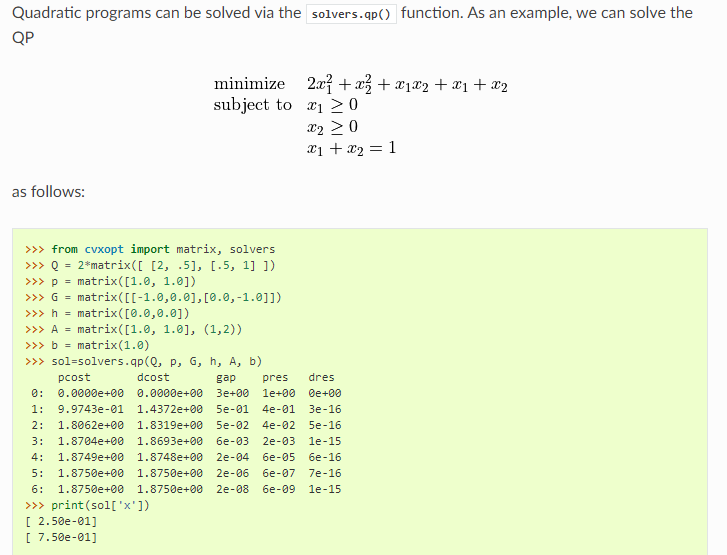

# Algorithm:

    1) given data -Scaling the features
    
    2) choose kernel type and find kernel matrix  
    
    3) solve dual , cvxopt.solvers.qp(P, q, G, h, A, b) 
    
    4) find multipliers\coefficient  (solution of problem)
    
    5) choose non zero coefficient (support multiplier) and corresponding (support vector)
    
    6) update weights and bais for linear kernel
    
    7) for i in some values of C:  (insted of using kkt condition)
        find the dual
        which gives best accuracy
    

# SVM theory

Cost function
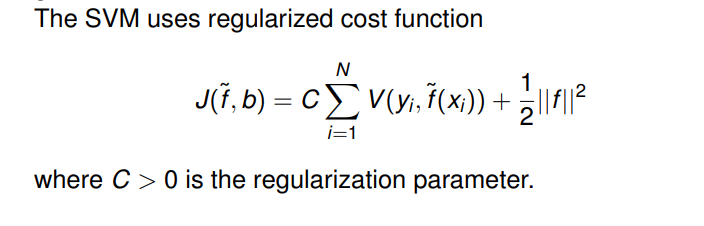

Primal Problem
Primal Problem is helpful in solving Linear SVM using SGD or optimization package. 
need to optimize D+1 parameters in Primal Problem.


When we have to solve Non-Linear SVM where Primal Problem is not helpful. 
so we go for dual problem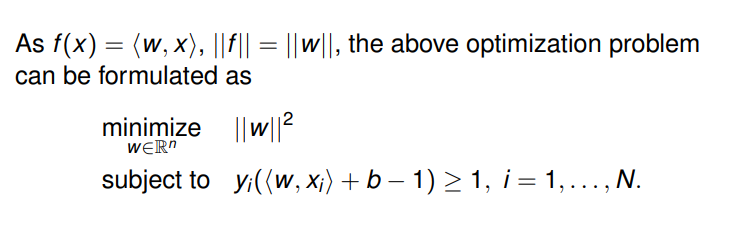


Duality
looking the optim problem from diffrent perspectives,
the primal problem or the dual problem (the duality principle). 
The solution to the dual problem provides a lower bound to the solution of the primal (minimization) problem.



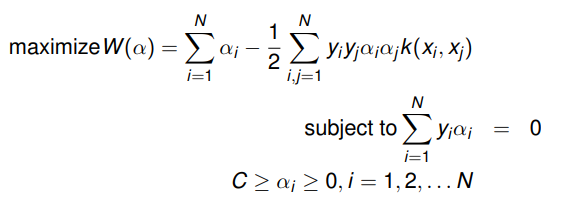

In [29]:
class SVM(object):
    
    def __init__(self, kernel):        
        self._kernel = kernel
        self._c = None      
        self.K = None
        self.data=None
        self._bias = None
        self._weights = None
        self._multipliers= None
        self._support_vectors = None
        self._support_vector_labels = None

        
    def find_matrix(self, X):
        n=X.shape[0]
        kernel_matrix = np.zeros([n,n])
        for i in range(n):
            for j in range(n):            
                kernel_matrix[i,j] = self.kernel(self._kernel,X[i],X[j])        
        return kernel_matrix     
    
    def kernel(self,kernel,xi,xj):
        if kernel == "Linear" :
            kernel_value = np.dot(xi,xj) 
        elif kernel =="Quadratic": 
            kernel_value = np.dot(xi,xj)**2 
        elif kernel == "Gaussian": 
            kernel_value = np.exp((-(la.norm(xi - xj))**2))
        return kernel_value

    def train(self, X, y):      
        self.C_mul=[]
        r,c=X.shape
        lambdas=[]
        lambdas1=[]
        c_value=[1000000000000,10000,1000,100]
        for i in c_value:
            self._c=i
            self.C_mul.append(self._c)
            lambdas.append(self.find_multipliers(X, y,self._c))  #...solving dual optimization problem 
            lambdas1.append(self.find_multipliers_primal(X, y,self._c))     #...solving primal optimization problem    
        
        print('Dual')
        print("----------------")
        self.get_ans(X,y,lambdas)
#         print('primal')
#         print("----------------")
#         self.get_ans(X,y,lambdas1)
    
    def get_ans(self,X,y,lambdas):       
        k=[]
        r,c=X.shape        
        biass=[]
        weightss=[]
        multiplierss=[]
        support_vectorss=[]
        support_vector_labelss=[]
        
        for lmd in lambdas:        
            # Support vectors have non zero lagrange multipliers
            # select thoes which are > 0.0001        
            loc = lmd > 0.0001  # take location of non zero eigen values
            sv_ind = np.arange(len(lmd))[loc]        
            spt_mul= lmd[loc]        
            spt_vec = X[loc]
            spt_vec_lbl = y[loc]
            # bias
            bias = 0
            for n in range(len(spt_mul)):
                bias +=  spt_vec_lbl[n]
                bias -= np.sum(spt_mul* spt_vec_lbl * self.K[sv_ind[n],loc])
            bias /= len(spt_mul)

            # Weight vector
            if self._kernel == "Linear":
                weights = np.zeros(c)
                for n in range(len(spt_mul)):
                    weights += spt_mul[n] * spt_vec_lbl[n] * spt_vec[n]
            else:
                weights = spt_mul             
            
            k.append(self.measure(X,y,bias,weights,spt_vec,spt_vec_lbl))
            
            biass.append( bias)
            weightss.append( weights)
            multiplierss.append(spt_mul)
            support_vectorss.append(spt_vec)
            support_vector_labelss.append(spt_vec_lbl)           
                        
        
        k=np.array(k)
        ind=np.argmax(k)        
        self._c=self.C_mul[ind]
        self._bias=biass[ind]
        self._weights=weightss[ind]
        self._multipliers=multiplierss[ind]
        self._support_vectors=support_vectorss[ind]
        self._support_vector_label=support_vector_labelss[ind]
        
        print(" ")
        print("--------------------------------------------------------------------- ")
        print("C:------------ ", self._c)
        print("Bias:------------ ", self._bias)
        print("Weights:------", self._weights)
        print("Total Support vectors: \n ", len(self._support_vectors))
        print("Support vector labels:", self._support_vector_label)
        print(" ")        
       
    
    
    def find_multipliers_primal(self, X, y,C):
        y1  = y.reshape(-1,1)* 1.       
        m, n = X.shape         
        # To solve primal form using cvxopt, we need 4 matrix parameters P, q, G and h
        P = np.zeros((n + m + 1, n + m + 1))
        for i in range(n):
            P[i, i] = 1
        P = cm(P)

        # calculating q
        q = np.zeros((m + n + 1, 1))
        for i in range(n + 1, n + m + 1):
            q[i, 0] = C * 1
        q = cm(q)  
        
        # calculating G
        G = np.zeros((2 * m, n + m + 1))
        G[:m, 0:n] = y1 * X
        G[:m, n] = y1.T
        G[:m, n + 1:] = np.identity(m)
        G[m:, n + 1:] = np.identity(m)
        G = cm(G * -1)        
        # calculating h
        h = np.zeros((2 * m, 1))
        h[:m] = -1
        h = cm(h)        
        # solving quadratic programming problem to minimize w, b and slack variable E
        solution = cvxopt.solvers.qp(P, q, G, h)  
        solution = np.ravel(solution['x'])             
        return solution

    def find_multipliers(self, X, y,C):        
        r, c = X.shape        
        K = self.find_matrix(X)        
        self.K = K
        y  = y.reshape(-1,1)* 1.
        y_k = y * K
        H = np.dot(y_k,y_k.T)* 1.        
        P = cm(H)  
        q = cm(-1 * np.ones(r))
        tmp1 = np.diag(np.ones(r) * -1)
        tmp2 = np.eye(r)
        G = cm(np.vstack((tmp1, tmp2)))
        tmp3 = np.zeros(r)
        tmp4 = np.ones(r) * C
        h = cm(np.hstack((tmp3, tmp4)))
        A = cm(y.T)
        b = cm(np.zeros(1)*1.)        
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)        
        sol=np.ravel(solution['x'])
        return sol
    
    def predictor(self, x,bias,weights, svlbl, svec):        
        result =bias           
        for z_i, x_i, y_i in zip(weights,svec,svlbl):            
            result += z_i * y_i * self.kernel(self._kernel,x_i, x)
        result=np.sign(np.sum(result, axis = 1))        
        return result
    
    def predict_linear(self,X, weights, bias):
        r,c=X.shape
        print(weights)
        weights=np.array(weights).reshape((c,1))        
        prediction = bias + np.dot(X, weights)
        
        # yi = b + xi.w
        prediction[prediction > 0] =  1   # classifying values above 0 as of class 1
        prediction[prediction < 0] = -1   # classifying values below 0 as of class -1
        return prediction

    def predict_Gauss(self, X, bias,weights, svlbl, svec):
        r,c=X.shape
        y_predict = np.zeros(r)         
        for i in range(r):
            result =bias
            for m, y, sv in zip(weights, svlbl, svec):
                result += m * y * self.kernel(self._kernel,X[i], sv)
            y_predict[i] = result        
        z=np.sign(y_predict)        
        return z
            
    def measure(self,x,y,bias,weights, svlbl, svec):
        y= y*1.        
        if self._kernel=='Gaussian':
            y_pred= self.predict_Gauss(x,bias,weights, svlbl, svec) 
            acc= accuracy_score(y,y_pred)
        elif self._kernel=='Quadratic':
            y_pred= self.predictor(x,bias,weights, svlbl, svec)            
            acc= accuracy_score(y,y_pred)
        else:
            y_pred= self.predict_linear(x,weights,bias)   
            
            acc= accuracy_score(y,y_pred)
        return acc

# Plot function for svm

In [30]:
import pylab as pl

def plot_margin(X1_train, X2_train, model):
        def f(x, w, b,eps):
            # given x, return y such that [x,y] in on the line
            # w.x + b = eps
            return (-w[0] * x - b + eps) / w[1]
        
        #plotting points       
        
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")        
        pl.scatter(model._support_vectors[:,0], model._support_vectors[:,1], s=150, c="y")
        # w.x + b = 0        
        a0 = -5; a1 = f(a0, model._weights, model._bias,0 )
        b0 = 5; b1 = f(b0, model._weights, model._bias,0 )
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -5; a1 = f(a0, model._weights, model._bias,1)
        b0 = 5; b1 = f(b0, model._weights, model._bias,1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -5; a1 = f(a0, model._weights, model._bias, -1)
        b0 = 5; b1 = f(b0, model._weights, model._bias, -1)
        pl.plot([a0,b0], [a1,b1], "k--")
        pl.axis("tight")
        pl.show()

def plot_contour(X1_train, X2_train, model):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(model._support_vectors[:,0], model._support_vectors[:,1], s=150, c="y")

        X1, X2 = np.meshgrid(np.linspace(-5,5,50), np.linspace(-5,5,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = model.predictor(X,model._bias,model._weights,model._support_vectors,model._support_vector_label).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

# Creating Test function

In [31]:
  def test(kernel,feature,target):
        X_train, X_test, y_train, y_test = train_test_split(feature,target,test_size=0.3)
        model=SVM(kernel)        
        model.train(X_train,y_train)         
        a=model.measure(X_test,y_test,model._bias,model._weights,model._support_vectors,model._support_vector_label)                       
        print("accuracy of predicted data---",a)
        if kernel=="Linear": 
            plot_margin(X_train[y_train==1], X_train[y_train==-1], model)
        else:
            plot_contour(X_train[y_train==1], X_train[y_train==-1], model)   

# Assignment 3

# 3. Apply SVM classification on Data1, Data2, Data3 and Data4. 

Choose the kernel as follows:

    for Data 1 & Data 2, k(x, y) = <hx, yi>
    
    for Data 3 & Data 4, k(x, y) = <hx, yi>2.
    
(a) Apply Lagrangian optimization techniques to solve the dual.

(b) Plot the decision boundary and the SVM points.

(d) Find the value of primal and dual objective function. Report the value of the duality gap.

(e) Report the values of α, w and b.

(f) Assess the performance of the model.

# Reading and Ploting data

,X1,X2,Classs
0,5.3313,4.5792,-1
1,4.3385,4.1576,-1
2,4.4371,5.0997,1
3,4.4616,4.0029,-1
4,6.5034,1.6820,-1


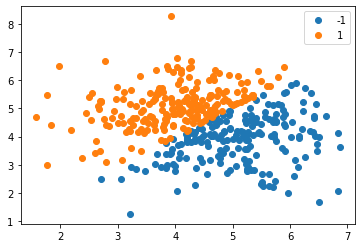

In [32]:
df=pd.read_csv('data1',header=None)
data1 = pd.DataFrame({"X1": df.iloc[:,0], "X2": df.iloc[:,1], "Classs": df.iloc[:,2]})
groups = data1.groupby("Classs")
for name, group in groups:
    plt.plot(group["X1"], group["X2"], marker="o", linestyle="", label=name)
plt.legend()

#Spliting data

target1 = np.array(data1.iloc[:,-1])
feature1 = np.array(data1.iloc[:,0:data1.shape[1]- 1])
feature1 = scale(feature1)
data1.head()

# Passing  Features and Target value

     pcost       dcost       gap    pres   dres
 0:  8.2148e+20 -2.5548e+26  8e+26  1e+00  1e+00
 1:  3.2839e+21 -9.9453e+25  2e+26  2e-01  1e+06
 2:  7.2410e+21 -1.7240e+25  3e+25  3e-02  3e+05
 3:  9.4632e+21 -7.1774e+24  1e+25  1e-02  1e+05
 4:  1.1165e+22 -1.8193e+24  3e+24  3e-03  2e+04
 5:  1.2555e+22 -3.2838e+23  5e+23  3e-04  3e+03
 6:  7.7133e+21 -1.1078e+22  2e+22  2e-05  3e+01
 7:  1.1938e+21 -1.2885e+21  2e+21  2e-06  3e-02
 8:  1.7119e+20 -1.8850e+20  4e+20  1e-07  4e-04
 9:  2.4530e+19 -2.6957e+19  5e+19  3e-07  2e-04
10:  3.5152e+18 -3.8633e+18  7e+18  2e-07  6e-05
11:  5.0371e+17 -5.5359e+17  1e+18  2e-08  2e-05
12:  7.2181e+16 -7.9327e+16  2e+17  2e-08  8e-06
13:  1.0343e+16 -1.1367e+16  2e+16  9e-09  3e-06
14:  1.4822e+15 -1.6289e+15  3e+15  5e-09  1e-06
15:  2.1239e+14 -2.3342e+14  4e+14  2e-09  4e-07
16:  3.0435e+13 -3.3448e+13  6e+13  3e-11  2e-07
17:  4.3613e+12 -4.7930e+12  9e+12  3e-10  7e-08
18:  6.2496e+11 -6.8683e+11  1e+12  1e-11  3e-08
19:  8.9555e+10 -9.84

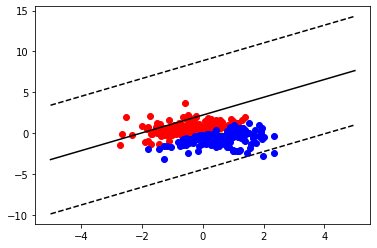

In [33]:
test('Linear',feature1,target1)

# DATA 2

,0,1,2
0,1.70600,2.8859,1
1,-0.70611,3.5617,-1
2,3.42530,1.9469,1
3,2.53570,1.5779,1
4,1.68960,3.4147,-1


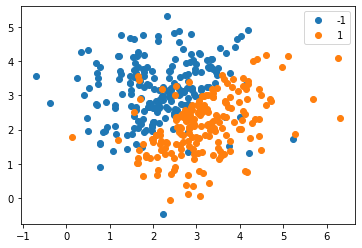

In [9]:
df2=pd.read_csv('data2',header=None)
data2 = pd.DataFrame({"X1": df2.iloc[:,0], "X2": df2.iloc[:,1], "Classs": df2.iloc[:,2]})
groups = data2.groupby("Classs")
for name, group in groups:
    plt.plot(group["X1"], group["X2"], marker="o", linestyle="", label=name)
plt.legend()
target2 = np.array(df2.iloc[:,-1])
feature2 = np.array(df2.iloc[:,0:df2.shape[1]- 1])
df2.head()

# Passing  Features and Target value

     pcost       dcost       gap    pres   dres
 0: -7.1092e+05 -2.0234e+10  4e+10  6e-01  3e-06
 1: -4.3753e+05 -5.8642e+09  7e+09  4e-02  1e-06
 2: -5.7910e+05 -3.3795e+08  3e+08  1e-03  9e-07
 3: -5.8272e+05 -5.9585e+06  5e+06  2e-05  8e-07
 4: -6.6336e+05 -1.8426e+06  1e+06  3e-06  1e-06
 5: -7.3236e+05 -1.6532e+06  9e+05  2e-06  9e-07
 6: -7.9680e+05 -1.4424e+06  6e+05  1e-06  1e-06
 7: -8.4564e+05 -1.2874e+06  4e+05  9e-07  1e-06
 8: -8.9034e+05 -1.1606e+06  3e+05  5e-07  1e-06
 9: -9.2165e+05 -1.0967e+06  2e+05  3e-07  1e-06
10: -9.4144e+05 -1.0571e+06  1e+05  2e-07  1e-06
11: -9.5804e+05 -1.0274e+06  7e+04  1e-07  2e-06
12: -9.7091e+05 -1.0043e+06  3e+04  4e-08  1e-06
13: -9.7669e+05 -9.9544e+05  2e+04  2e-08  1e-06
14: -9.8129e+05 -9.8887e+05  8e+03  5e-09  1e-06
15: -9.8183e+05 -9.8777e+05  6e+03  3e-09  2e-06
16: -9.8395e+05 -9.8504e+05  1e+03  4e-12  2e-06
17: -9.8439e+05 -9.8457e+05  2e+02  4e-12  2e-06
18: -9.8447e+05 -9.8449e+05  1e+01  2e-11  2e-06
19: -9.8448e+05 -9.84

14:  4.9260e+03  4.9258e+03  3e-01  3e-07  2e-08
15:  4.9259e+03  4.9259e+03  3e-02  1e-08  6e-10
16:  4.9259e+03  4.9259e+03  3e-04  1e-10  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.6228e+02 -2.5052e+04  6e+04  8e-01  2e-09
 1: -7.0340e+02 -9.3896e+03  1e+04  8e-02  1e-09
 2: -6.6209e+02 -1.8237e+03  1e+03  7e-03  1e-09
 3: -8.3081e+02 -1.2858e+03  5e+02  2e-03  1e-09
 4: -8.7561e+02 -1.1899e+03  3e+02  1e-03  1e-09
 5: -9.2597e+02 -1.0813e+03  2e+02  6e-04  1e-09
 6: -9.4992e+02 -1.0381e+03  9e+01  3e-04  1e-09
 7: -9.6454e+02 -1.0144e+03  5e+01  1e-04  1e-09
 8: -9.7423e+02 -9.9946e+02  3e+01  7e-05  1e-09
 9: -9.8054e+02 -9.8994e+02  9e+00  2e-05  1e-09
10: -9.8215e+02 -9.8735e+02  5e+00  5e-06  2e-09
11: -9.8409e+02 -9.8492e+02  8e-01  1e-14  2e-09
12: -9.8443e+02 -9.8456e+02  1e-01  5e-14  2e-09
13: -9.8449e+02 -9.8450e+02  9e-03  3e-14  2e-09
14: -9.8449e+02 -9.8449e+02  7e-04  1e-14  2e-09
Optimal solution found.
     pcost       dcost

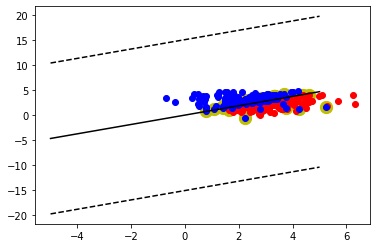

In [10]:
test('Linear',feature2,target2)

# DATA 3

,0,1,2
0,-0.20527,-0.645210,1
1,-1.41680,-0.988330,1
2,0.79969,0.093650,1
3,-1.56630,0.082371,1
4,-0.78550,-0.226450,1


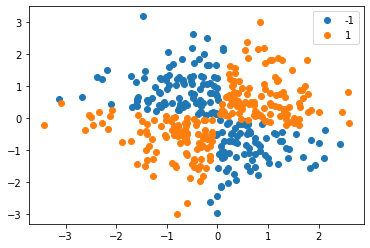

In [11]:
df3=pd.read_csv('data3',header=None)
data3 = pd.DataFrame({"X1": df3.iloc[:,0], "X2": df3.iloc[:,1], "Classs": df3.iloc[:,2]})
groups = data3.groupby("Classs")
for name, group in groups:
    plt.plot(group["X1"], group["X2"], marker="o", linestyle="", label=name)
plt.legend()
target3 = np.array(df3.iloc[:,-1])
feature3 = np.array(df3.iloc[:,0:df3.shape[1]- 1])
feature3= scale(feature3)
df3.head()

# Passing  Features and Target value

     pcost       dcost       gap    pres   dres
 0: -7.2868e+05 -4.5847e+10  2e+11  2e+00  2e-07
 1: -4.2077e+05 -2.8951e+10  5e+10  3e-01  1e-07
 2:  5.1654e+05 -1.0115e+10  2e+10  1e-01  8e-08
 3:  1.3401e+06 -2.3192e+09  4e+09  2e-02  3e-08
 4:  1.8404e+06 -4.4023e+08  7e+08  4e-03  2e-08
 5:  1.5025e+06 -7.9450e+07  1e+08  5e-04  2e-08
 6:  7.5029e+04 -8.5106e+06  9e+06  4e-12  2e-08
 7: -6.2964e+04 -3.4996e+05  3e+05  3e-11  2e-08
 8: -7.5056e+04 -2.8529e+05  2e+05  2e-11  2e-08
 9: -6.7417e+04 -2.7223e+05  2e+05  2e-11  2e-08
10: -8.3391e+04 -2.8278e+05  2e+05  1e-11  2e-08
11: -8.3891e+04 -2.7728e+05  2e+05  7e-12  2e-08
12: -7.4772e+04 -2.6729e+05  2e+05  5e-12  2e-08
13: -8.8780e+04 -2.5030e+05  2e+05  2e-12  2e-08
14: -8.3191e+04 -2.4438e+05  2e+05  1e-12  2e-08
15: -9.6207e+04 -2.3390e+05  1e+05  2e-12  2e-08
16: -1.0874e+05 -2.2796e+05  1e+05  1e-12  2e-08
17: -1.1245e+05 -2.0605e+05  9e+04  2e-11  2e-08
18: -1.1470e+05 -1.8680e+05  7e+04  7e-12  2e-08
19: -1.1737e+05 -1.82

     pcost       dcost       gap    pres   dres
 0: -1.5346e+02 -1.1968e+03  1e+04  5e+00  4e-11
 1: -9.2050e+01 -9.5535e+02  2e+03  8e-01  3e-11
 2: -6.6607e+01 -4.8799e+02  7e+02  2e-01  1e-11
 3: -4.8540e+01 -1.6794e+02  2e+02  7e-02  6e-12
 4: -4.0793e+01 -7.0102e+01  7e+01  2e-02  4e-12
 5: -3.6703e+01 -5.4595e+01  5e+01  1e-02  3e-12
 6: -3.4750e+01 -4.5402e+01  4e+01  1e-02  3e-12
 7: -3.1813e+01 -3.8773e+01  3e+01  8e-03  3e-12
 8: -2.9700e+01 -3.6215e+01  3e+01  7e-03  3e-12
 9: -2.7158e+01 -3.2997e+01  3e+01  5e-03  3e-12
10: -2.5644e+01 -3.1388e+01  2e+01  4e-03  3e-12
11: -2.3264e+01 -2.8011e+01  2e+01  3e-03  3e-12
12: -2.0944e+01 -2.6128e+01  2e+01  2e-03  3e-12
13: -1.9664e+01 -2.2400e+01  9e+00  1e-03  3e-12
14: -1.8879e+01 -2.1459e+01  7e+00  7e-04  3e-12
15: -1.8157e+01 -2.0315e+01  5e+00  4e-04  3e-12
16: -1.7981e+01 -1.8776e+01  2e+00  1e-04  3e-12
17: -1.8008e+01 -1.8052e+01  8e-02  6e-06  4e-12
18: -1.8012e+01 -1.8012e+01  8e-04  6e-08  4e-12
19: -1.8012e+01 -1.80

<ipython-input-5-1e34a0e63ea3>:40: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
<ipython-input-5-1e34a0e63ea3>:41: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')


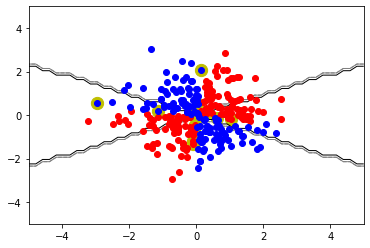

In [12]:
test('Quadratic',feature3,target3)

# DATA 4

,0,1,2
0,0.80263,-1.400600,-1
1,-0.46134,0.090394,-1
2,-3.40530,-0.293270,1
3,-0.93596,0.329820,-1
4,1.20120,-0.726610,-1


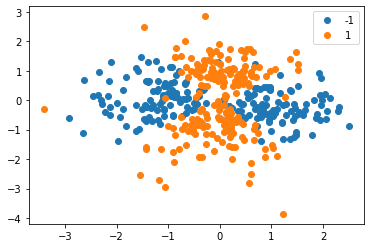

In [13]:
df4=pd.read_csv('data4',header=None)
data4 = pd.DataFrame({"X1": df4.iloc[:,0], "X2": df4.iloc[:,1], "Classs": df4.iloc[:,2]})
groups = data4.groupby("Classs")
for name, group in groups:
    plt.plot(group["X1"], group["X2"], marker="o", linestyle="", label=name)
plt.legend()
target4 = np.array(df4.iloc[:,-1])
feature4 = np.array(df4.iloc[:,0:df4.shape[1]- 1])
feature4 = scale(feature4)
df4.head()

# Passing  Features and Target value

     pcost       dcost       gap    pres   dres
 0: -7.9457e+05 -2.8195e+10  8e+10  1e+00  2e-07
 1: -5.3550e+05 -1.4456e+10  2e+10  2e-01  2e-07
 2: -2.2039e+05 -2.8531e+09  4e+09  3e-02  4e-08
 3: -2.9640e+05 -4.4868e+08  5e+08  2e-03  3e-08
 4: -3.1552e+05 -8.4697e+06  8e+06  3e-05  3e-08
 5: -3.4401e+05 -1.6998e+06  1e+06  4e-06  2e-08
 6: -4.0296e+05 -1.4376e+06  1e+06  3e-06  3e-08
 7: -4.3525e+05 -1.3237e+06  9e+05  2e-06  3e-08
 8: -4.7143e+05 -1.1137e+06  6e+05  1e-06  2e-08
 9: -4.9705e+05 -9.8724e+05  5e+05  8e-07  2e-08
10: -5.2432e+05 -8.7789e+05  4e+05  5e-07  4e-08
11: -5.5118e+05 -7.9879e+05  2e+05  3e-07  3e-08
12: -5.7966e+05 -7.3141e+05  2e+05  2e-07  3e-08
13: -5.9381e+05 -6.9955e+05  1e+05  1e-07  3e-08
14: -6.0514e+05 -6.7397e+05  7e+04  6e-08  3e-08
15: -6.1383e+05 -6.5246e+05  4e+04  1e-08  4e-08
16: -6.2199e+05 -6.3785e+05  2e+04  9e-13  4e-08
17: -6.2673e+05 -6.3252e+05  6e+03  2e-12  3e-08
18: -6.2871e+05 -6.3015e+05  1e+03  5e-12  4e-08
19: -6.2935e+05 -6.29

     pcost       dcost       gap    pres   dres
 0: -1.6199e+02 -8.4378e+02  5e+03  3e+00  5e-11
 1: -1.0481e+02 -6.2463e+02  1e+03  6e-01  3e-11
 2: -8.0152e+01 -3.2087e+02  4e+02  2e-01  2e-11
 3: -6.6276e+01 -1.4254e+02  1e+02  7e-02  5e-12
 4: -6.2072e+01 -8.4333e+01  4e+01  2e-02  4e-12
 5: -6.1358e+01 -6.9159e+01  1e+01  4e-03  4e-12
 6: -6.2263e+01 -6.4433e+01  3e+00  5e-04  4e-12
 7: -6.2597e+01 -6.3530e+01  1e+00  1e-04  3e-12
 8: -6.2873e+01 -6.3076e+01  2e-01  2e-05  3e-12
 9: -6.2955e+01 -6.2960e+01  5e-03  1e-07  4e-12
10: -6.2957e+01 -6.2957e+01  5e-05  1e-09  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2978e+00  6.2039e+02  2e+03  3e+00  3e+00
 1:  4.2264e+02  2.1991e+02  2e+02  5e-16  2e-15
 2:  3.0387e+02  2.5221e+02  5e+01  3e-16  2e-15
 3:  2.8848e+02  2.5766e+02  3e+01  3e-16  5e-15
 4:  2.7767e+02  2.6260e+02  2e+01  3e-16  8e-15
 5:  2.7089e+02  2.6622e+02  5e+00  3e-16  4e-15
 6:  2.6900e+02  2.6741e+02  2e+00  3e-16  8e-1

<ipython-input-5-1e34a0e63ea3>:39: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
<ipython-input-5-1e34a0e63ea3>:40: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
<ipython-input-5-1e34a0e63ea3>:41: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')


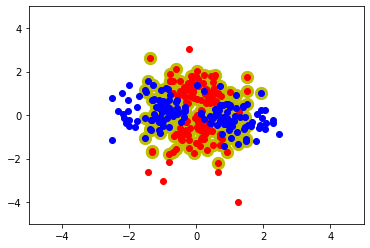

In [14]:
test('Quadratic',feature4,target4)

# 6. Apply SVM on Data 5.

(a) Apply Lagrangian optimization.

(b) Discuss the technique used to find the optimal kernel and other hyperparameters.

(c) Plot the decision boundary and support vectors.

(d) Report the values of the parameters and hyperparameters of the model.

(e) Assess the performance of the model.

,0,1,2
0,3.8737,3.3983,-1
1,3.0308,3.0174,-1
2,3.1599,3.7596,1
3,2.5971,2.9184,1
4,3.3975,3.0635,-1


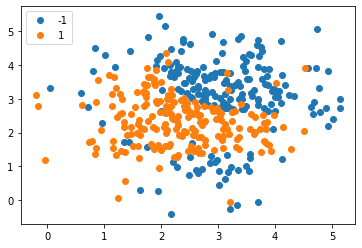

In [18]:
df5=pd.read_csv('data5',header=None)
data5 = pd.DataFrame({"X1": df5.iloc[:,0], "X2": df5.iloc[:,1], "Classs": df5.iloc[:,2]})
groups = data5.groupby("Classs")
for name, group in groups:
    plt.plot(group["X1"], group["X2"], marker="o", linestyle="", label=name)
plt.legend()
target5 = np.array(df5.iloc[:,-1])
feature5 = np.array(df5.iloc[:,0:df5.shape[1]- 1])
df5.head()

     pcost       dcost       gap    pres   dres
 0: -1.0473e+02 -7.0167e+01  3e+03  3e+01  9e-08
 1: -1.7739e+01 -6.6903e+01  2e+02  1e+00  9e-08
 2: -1.2966e+01 -4.1711e+01  4e+01  2e-01  1e-08
 3: -1.3577e+01 -1.7585e+01  4e+00  2e-02  8e-09
 4: -1.5083e+01 -1.5909e+01  9e-01  2e-03  1e-08
 5: -1.5325e+01 -1.5629e+01  3e-01  6e-04  9e-09
 6: -1.5441e+01 -1.5492e+01  5e-02  8e-05  1e-08
 7: -1.5462e+01 -1.5468e+01  6e-03  9e-06  1e-08
 8: -1.5463e+01 -1.5467e+01  4e-03  5e-06  8e-09
 9: -1.5465e+01 -1.5465e+01  8e-04  6e-07  9e-09
10: -1.5465e+01 -1.5465e+01  6e-05  1e-08  1e-08
11: -1.5465e+01 -1.5465e+01  8e-07  1e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.8785e+00  1.7414e+02  3e+03  3e+00  1e+02
 1:  6.5618e+01 -5.9051e+01  1e+02  1e-01  5e+00
 2:  3.3680e+01  1.3954e+01  2e+01  6e-04  3e-02
 3:  1.9570e+01  1.6448e+01  3e+00  9e-05  4e-03
 4:  1.8310e+01  1.7704e+01  6e-01  1e-05  6e-04
 5:  1.8061e+01  1.7946e+01  1e-01  2e-06  9e-0

 0.1       ]
Total Support vectors: 
  157
Support vector labels: [ 1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1
 -1  1  1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1 -1  1
 -1  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1  1
 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1
  1 -1  1  1 -1  1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1 -1 -1  1 -1  1 -1
 -1  1  1  1 -1 -1  1 -1  1 -1  1  1  1]
 
accuracy of predicted data--- 0.45


<ipython-input-5-1e34a0e63ea3>:39: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
<ipython-input-5-1e34a0e63ea3>:40: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
<ipython-input-5-1e34a0e63ea3>:41: UserWarning: No contour levels were found within the data range.
  pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')


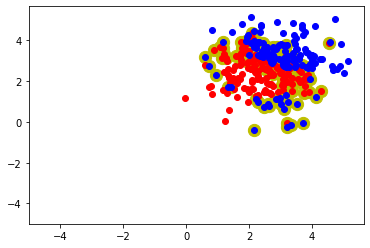

In [19]:
test('Quadratic',feature5,target5)